**Title of Project**:
Plant Disease Recognition using Deep Learning

**Objective**: To develop a deep learning model that can classify plant diseases from images using a Convolutional Neural Network (CNN) model, specifically a ResNet-34 architecture.

**Data Source:**

*   Training Data: ../input/plant-disease-recognition-dataset/Train/Train
*   Validation Data: ../input/plant-disease-recognition-dataset/Validation/Validation
*   Test Data: ../input/plant-disease-recognition-dataset/Test/Test






**Import Data**

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plant-disease-recognition-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1447507%2F2394131%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240906%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240906T155251Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D587c0c5ada5db03cf758971648c132d55ce5f09dc5705852a6c251f5a01c8347568a8c969d77600cbb9641e721278829a3aa0c756fb25c1bc960df26d64e2e75d5ad5eaa1693b379922e2528e0d826276ef4303d13fd20b59f20c5b67b4d319c5c759e5d95d9ef09a28d418bb9b9f6bbb31e0f5764a90abbc8ed58f7496b938461f725163711bbc068b0068e7402c7ce93ecbf7bea32a6fc7791194c4d268d7a0af70c9c02dcb8d94c63f0833f957952fbee93ee6217f42dce62987bf1c4ac4d1e7e2c9bdd9b02f46c090c433e91fcf0af887fbe1d5090787f1d3ff7ce6e2e386eb6894683957570002d49153da9088e7a002fa3852d9ea68ab216ea3527f669'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1339624018 bytes downloaded
Downloaded and uncompressed: plant-disease-recognition-dataset
Data source import complete.


**Describe Data**

The dataset consists of images of plant leaves, each associated with a specific plant disease or a healthy condition. It contains three sets:


*   Training set for model learning.
*   Validation set for model tuning.
*   Test set for evaluating the final model.



**Import Libraries**

In [2]:
!pip install -q addict

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models
from PIL import Image
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import os
import random
from addict import Dict
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging

# Functions

In [4]:
def seed_everything(seed:int=42) -> None:
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def get_optimizer(model:torch.nn.Module, name:str="SGD", parameters:dict={}) -> torch.optim.Optimizer:
    optimizers = {
        "SGD": torch.optim.SGD,
        "AdamW": torch.optim.AdamW,
        "Adam": torch.optim.Adam,
        "RMSprop": torch.optim.RMSprop,
    }

    instance = optimizers.get(name, "SGD")
    optimizer = instance(model.parameters(), **parameters)

    return optimizer


def get_scheduler(optimizer:torch.optim.Optimizer, name:str, parameters:dict):
    schedulers = {
        "ReduceLROnPlateau": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "LambdaLR": torch.optim.lr_scheduler.LambdaLR,
        "StepLR": torch.optim.lr_scheduler.StepLR,
        "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR,
        "MultiplicativeLR": torch.optim.lr_scheduler.MultiplicativeLR,
        "MultiStepLR": torch.optim.lr_scheduler.MultiStepLR,
    }

    instance = schedulers[name]
    scheduler = instance(optimizer, **parameters)

    return scheduler



def accuracy_score(predictions:torch.Tensor, targets:torch.Tensor) -> torch.Tensor:
    amount = (predictions == targets).sum()
    accuracy = amount / targets.size(0)

    return accuracy



def hide_spines(ax, spines=["top", "right", "left", "bottom"]):
    for spine in spines:
        ax.spines[spine].set_visible(False)

def plot_images(rows, cols, indexes, class_=0):
    min_index = min(indexes)
    max_index = max(indexes)
    fig = plt.figure(figsize=(3*cols, 3*rows))
    for i in range(*indexes):
        item = train_dataset[i]
        image = item.image
        label = item.label

        if label == class_:
            ax = fig.add_subplot(rows, cols, (i - min_index)+1)
            ax.imshow(image.permute(1, 2, 0))
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

    fig.text(s=f"{train_dataset.labels[class_]} leaves", x=0.125, y=0.9, fontweight="bold", fontfamily="serif", fontsize=20)
    fig.show()


def get_logger(name:str=__name__, format:str="[%(asctime)s][%(levelname)s]: %(message)s") -> logging.Logger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(format)

    file_handler = logging.FileHandler(name)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    stream_handler.setFormatter(formatter)

    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    logger.propagate = False

    return logger

**Data Preprocessing**

In [5]:
config = Dict({
    "train_path": "../input/plant-disease-recognition-dataset/Train/Train",
    "test_path": "../input/plant-disease-recognition-dataset/Test/Test",
    "validation_path": "../input/plant-disease-recognition-dataset/Validation/Validation"
})

train_config = Dict({
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "epochs": 5,
    "seed": 2021,
    "image_shape": (128, 128),
    "image_channels": 3,
    "num_workers": 0,
    "batch_size": 32,

    "augmentations": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        #A.Blur(p=1),
        ToTensorV2(),
    ]),
    "optimizer": {
        "type": "AdamW",
        "parameters": {
            "lr": 0.001,
            "weight_decay": 0.01,
        }
    },

    "scheduler": {
        "type": "ReduceLROnPlateau",
        "parameters": {
            "patience": 2,
            "mode": "min",
            "factor": 0.1,
        }
    }
})


seed_everything(train_config.seed)

In [6]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, path, augmentations=None, image_shape=(256, 256), channels="RGB"):
        self.__images_labels = []
        self.image_shape = image_shape
        self.channels = channels
        self.augmentations = augmentations

        if os.path.exists(path):
            self.labels = os.listdir(path)
            for label in self.labels:
                label_path = os.path.join(path, label)
                if os.path.isdir(label_path):
                    files = os.listdir(label_path)
                    for file in files:
                        if file.endswith("jpg") or file.endswith("png"):
                            image_path = os.path.join(label_path, file)
                            self.__images_labels.append((image_path, label))
                        else:
                            pass
                else:
                    pass

        else:
            pass

    def _load(self, path, channels="RGB"):
        width, height = self.image_shape
        loader = A.Compose([
            A.Resize(width=width, height=height),
            ToTensorV2(),
        ])

        image_array = np.array(Image.open(path).convert(channels))
        return loader(image=image_array)["image"]

    def __len__(self):
        return len(self.__images_labels)

    def __getitem__(self, index):
        path, label = self.__images_labels[index]
        image = self._load(path)

        if self.augmentations is not None:
            image = image.permute(1, 2, 0).numpy()
            image = self.augmentations(image=image)["image"]

        label = self.labels.index(label)

        return Dict({
            "image": image,
            "label": label,
        })


def collate_fn(batch):
    all_images, all_labels = [], []
    for item in batch:
        image = item.image
        label = item.label

        all_images.append(item.image.tolist())
        all_labels.append(label)

    return {
        "images": torch.tensor(all_images),
        "labels": torch.tensor(all_labels, dtype=torch.int8)
    }


**Data Visualization**

In [7]:
train_dataset = PlantDiseaseDataset(path=config.train_path,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

<ipython-input-8-db62384486d1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)


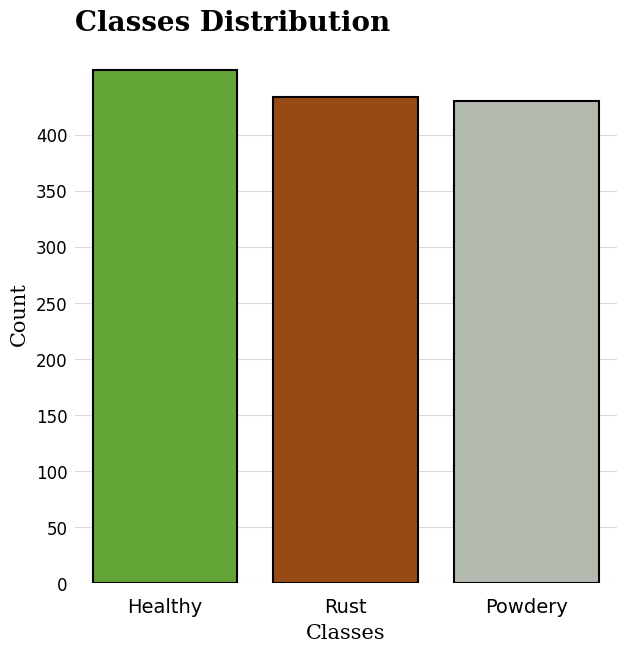

In [8]:
label_pathes = [os.path.join(config.train_path, label) for label in train_dataset.labels]
label_files = [os.listdir(path) for path in label_pathes]
amount = [len(files) for files in label_files]

palette = sns.color_palette(["#5FB924", "#AB4800", "#B2BBAC"])
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.barplot(x=train_dataset.labels, y=amount, palette=palette,  ec="#000", linewidth=1.5, zorder=2, ax=ax)
ax.xaxis.set_tick_params(labelsize=14, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_yticks(list(range(0, 450, 50)))
ax.set_title(f"Classes Distribution", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.01)
ax.set_xlabel("Classes", fontsize=15, fontfamily="serif", labelpad=5)
ax.set_ylabel("Count", fontsize=15, fontfamily="serif", labelpad=5)
hide_spines(ax)
fig.show()

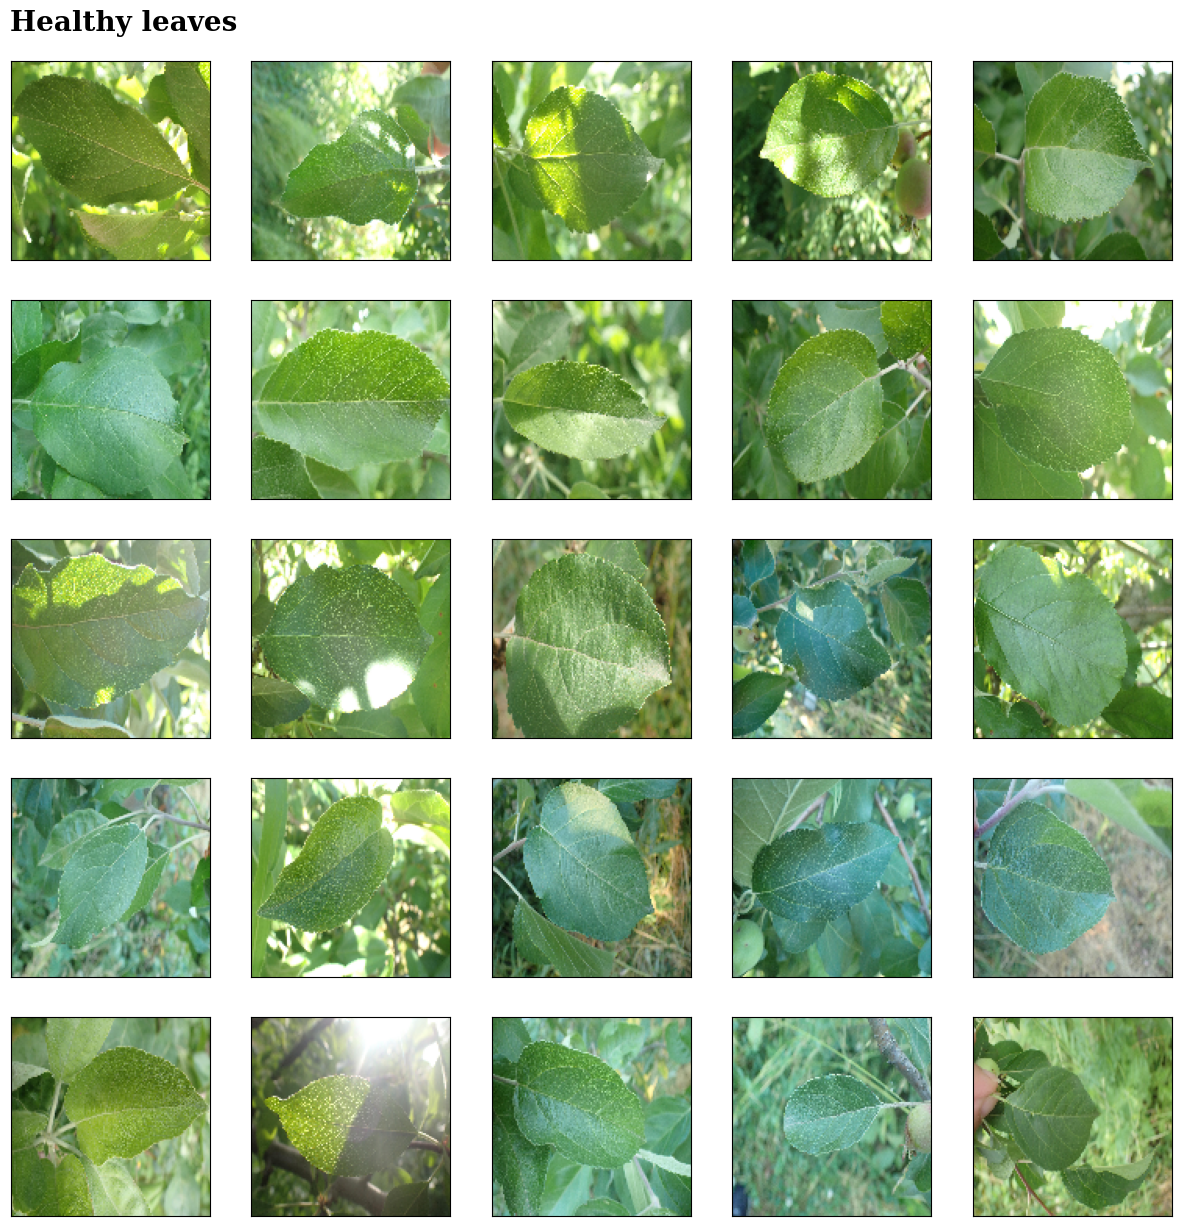

In [9]:
plot_images(rows=5, cols=5, indexes=(0, 25), class_=0)

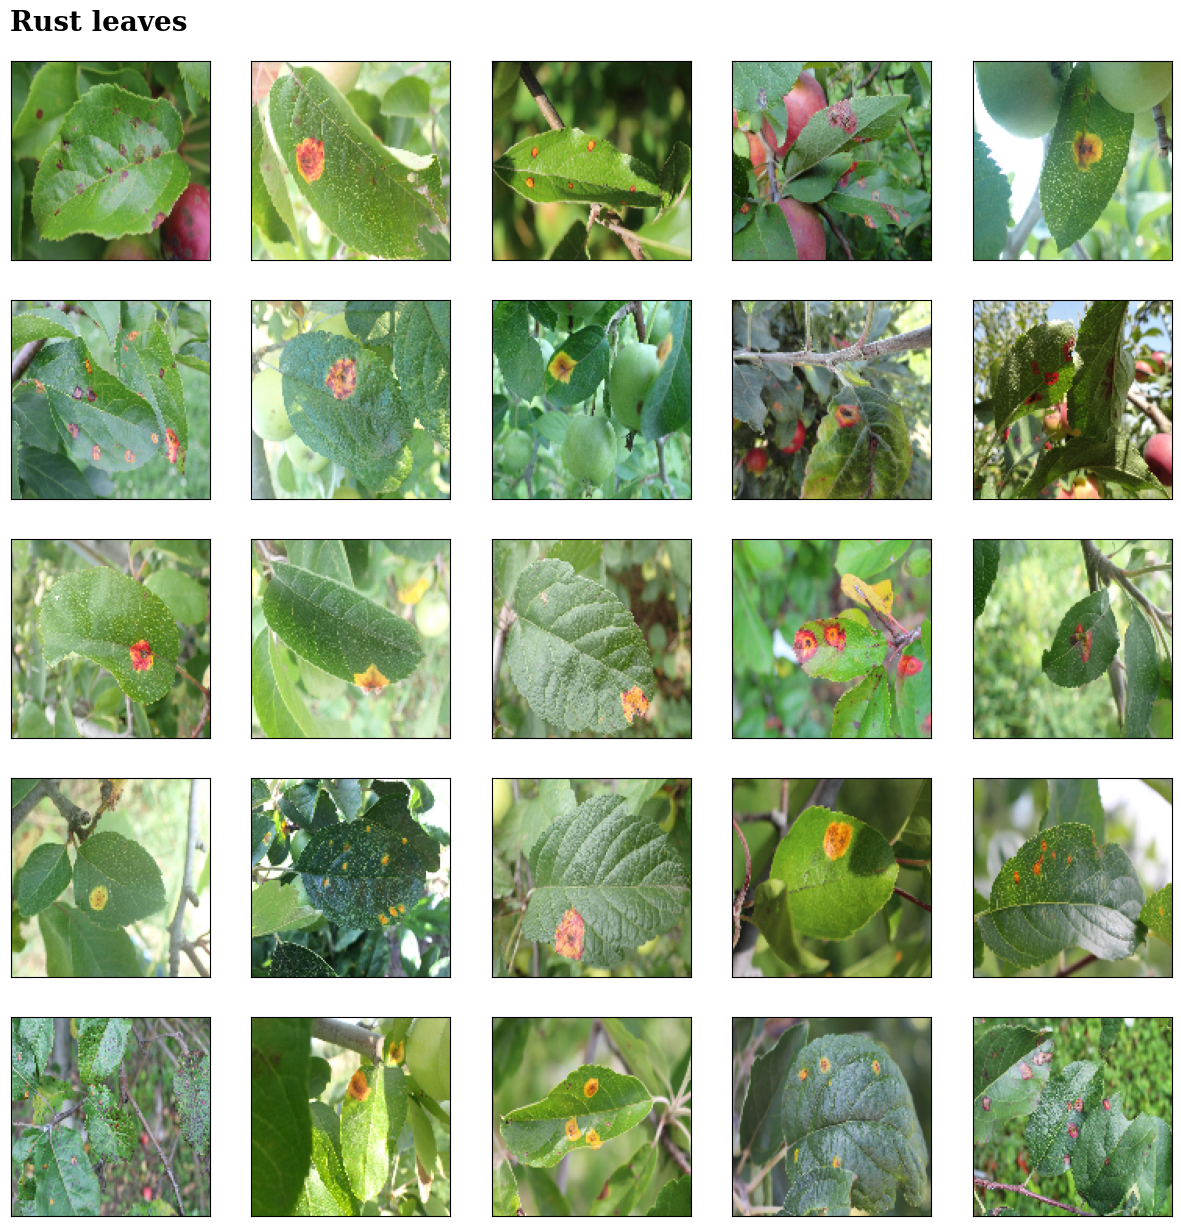

In [10]:
plot_images(rows=5, cols=5, indexes=(500, 525), class_=1)

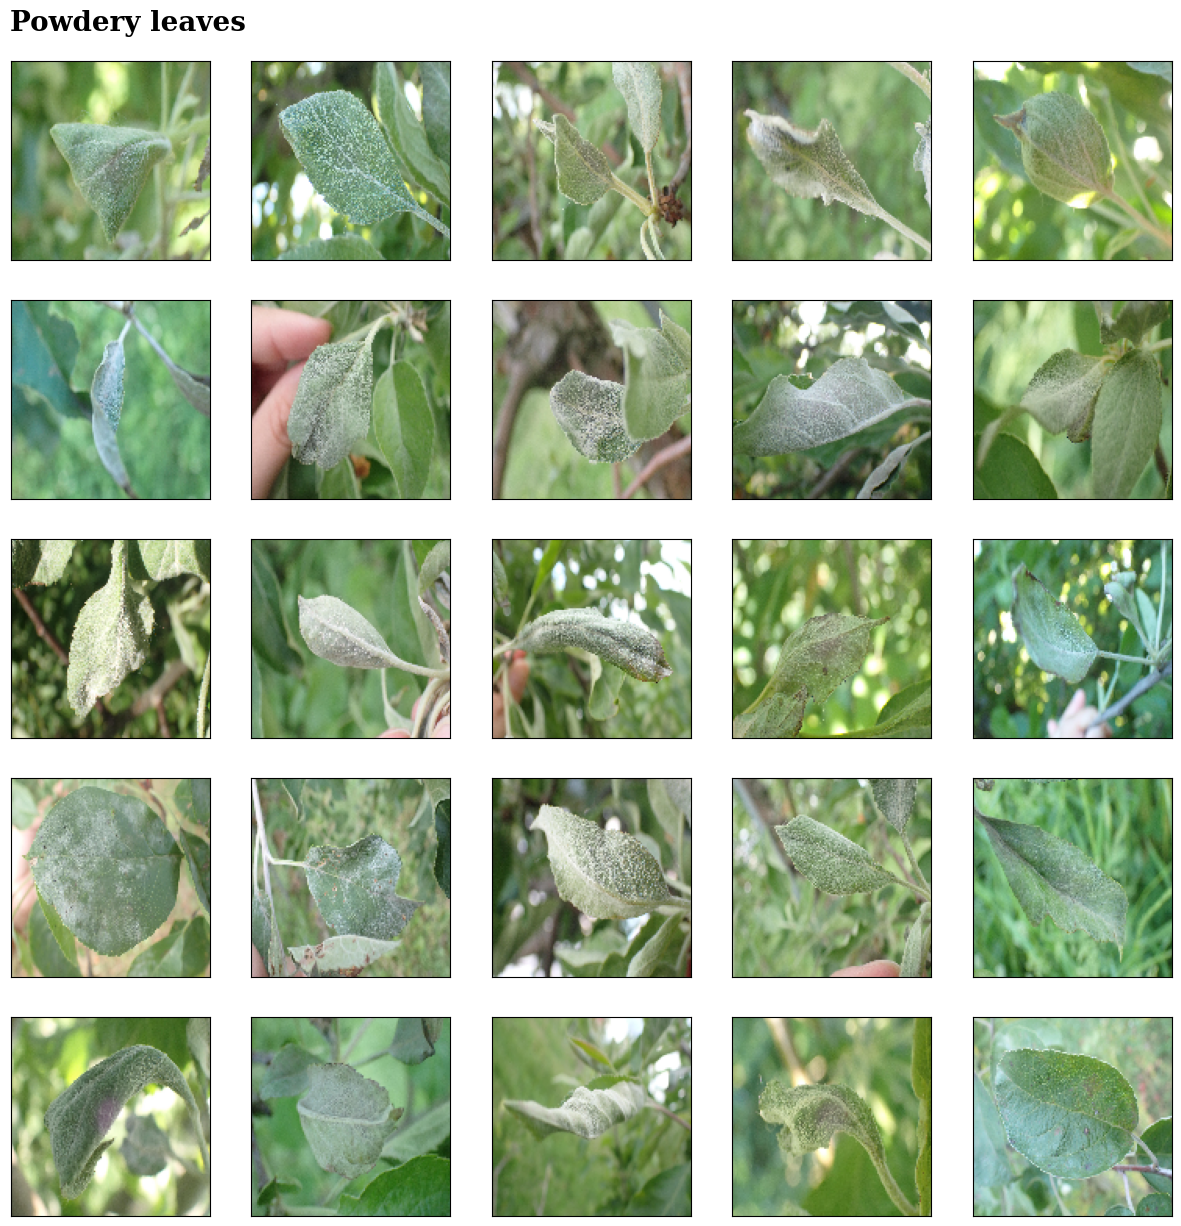

In [11]:
plot_images(rows=5, cols=5, indexes=(len(train_dataset)-25, len(train_dataset)), class_=2)

**DataLoader Preparation**

In [12]:
train_dataset = PlantDiseaseDataset(path=config.train_path,
                                    augmentations=train_config.augmentations,
                                    image_shape=train_config.image_shape,
                                    channels=train_config.image_channels)

validation_dataset = PlantDiseaseDataset(path=config.validation_path,
                                         augmentations=train_config.augmentations,
                                         image_shape=train_config.image_shape,
                                         channels=train_config.image_channels)

test_dataset = PlantDiseaseDataset(path=config.test_path,
                                   augmentations=train_config.augmentations,
                                   image_shape=train_config.image_shape,
                                   channels=train_config.image_channels)

In [13]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=train_config.batch_size,
                          num_workers=train_config.num_workers,
                          pin_memory=True,
                          shuffle=True,
                          collate_fn=collate_fn)

validation_loader = DataLoader(dataset=validation_dataset,
                               batch_size=train_config.batch_size*2,
                               num_workers=train_config.num_workers,
                               pin_memory=True,
                               shuffle=False,
                               collate_fn=collate_fn)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=train_config.batch_size*2,
                         num_workers=train_config.num_workers,
                         pin_memory=True,
                         shuffle=False,
                         collate_fn=collate_fn)

**Define Target Variable (y) and Feature Variables (X)**

*   Feature Variables (X): Images of plant leaves.
*   Target Variable (y): Labels corresponding to different plant diseases or healthy condition.



**Train-Test Split**

Handled through separate datasets for training, validation, and testing as defined in the PlantDiseaseDataset class.

**Modelling**

In [14]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, classes=2):
        super(PlantDiseaseModel, self).__init__()
        self.model = models.resnet34(pretrained=True)

        for parameter in self.model.parameters():
            parameter.require_grad = False

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=classes),
            nn.Softmax(dim=1)
        )

    def forward(self, image):
        output = self.model(image)
        return output

In [15]:
class Trainer:
    def __init__(self, model, criterion, optimizer,  metric, scheduler=None, logger=None, device="cpu"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.logger = logger
        self.device = torch.device(device)
        self.best_validation_loss = 0
        self.metric = metric
        self.history = Dict({})

    def __log(self, logs):
        for k, v in logs.items():
            if k not in self.history:
                self.history[k] = []

            self.history[k].append(v)

    def evaluate(self, loader):
        loss, score, length = 0, 0, len(loader)

        self.model.to(self.device)
        with torch.no_grad():
            loop = tqdm(loader, position=0, colour="BLACK", desc=f"Evaluating: ", leave=True)
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.model.eval()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                loss += batch_loss.item()

                batch_score = self.metric(predictions, labels).item()
                score += batch_score

            loss /= length
            score /= length

        return loss, score



    def fit(self, train_loader, validation_loader=None, epochs=10):
        self.model.to(self.device)
        train_length = len(train_loader)

        for epoch in range(epochs):
            epoch_loss, epoch_score = 0, 0

            loop = tqdm(train_loader, position=0, colour="BLACK", leave=True, desc=f"Epoch [{epoch+1}/{epochs}]: ")
            for batch in loop:
                if self.device.type != "cpu": torch.cuda.empty_cache()
                self.optimizer.zero_grad()
                self.model.train()

                images = batch["images"].float().to(self.device)
                labels = batch["labels"].long().to("cpu")

                probabilities = self.model(images).float().to("cpu")
                predictions = torch.argmax(probabilities, dim=1).detach()

                batch_loss = self.criterion(probabilities, labels)
                epoch_loss += batch_loss.item()

                batch_score = self.metric(predictions, labels).item()
                epoch_score += batch_score

                batch_loss.backward()
                self.optimizer.step()

            epoch_loss /= train_length
            epoch_score /= train_length

            self.__log({"train_losses": epoch_loss, "train_scores": epoch_score})
            if self.logger is not None: self.logger.info(f"Epoch [{epoch+1}/{epochs}]: Loss: {epoch_loss} | Metric: {epoch_score}")

            if validation_loader is not None:
                validation_loss, validation_score = self.evaluate(validation_loader)
                self.__log({"validation_losses": validation_loss, "validation_scores": validation_score})
                if self.logger is not None: self.logger.info(f"Validation Epoch [{epoch+1}/{epochs}]: Loss: {validation_loss} | Metric: {validation_score}")



                if self.scheduler is not None:
                    if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        self.scheduler.step(validation_loss)
                    else:
                        self.scheduler.step()

                    if self.logger is not None:
                        lr = self.optimizer.param_groups[0]["lr"]
                        self.logger.info(f"Epoch [{epoch+1}/{epochs}] Learning Rate: {lr}")

In [16]:
model = PlantDiseaseModel(classes=len(train_dataset.labels))
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(model=model,
                          name=train_config.optimizer.type,
                          parameters=train_config.optimizer.parameters)

if "scheduler" in train_config:
    scheduler = get_scheduler(optimizer=optimizer,
                              name=train_config.scheduler.type,
                              parameters=train_config.scheduler.parameters)

trainer_logger = get_logger("trainer")
trainer = Trainer(model=model,
                  criterion=criterion,
                  metric=accuracy_score,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  logger=trainer_logger,
                  device=train_config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 141MB/s]


**Model Evaluation**

In [17]:
trainer.fit(train_loader=train_loader,
            validation_loader=validation_loader,
            epochs=train_config.epochs)

Epoch [1/5]: 100%|██████████| 42/42 [06:53<00:00,  9.84s/it]
[2024-09-06 16:13:10,298][INFO]: Epoch [1/5]: Loss: 0.6974378128846487 | Metric: 0.8529761901923588
Evaluating: 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]
[2024-09-06 16:13:20,114][INFO]: Validation Epoch [1/5]: Loss: 0.8876534104347229 | Metric: 0.6666666865348816
[2024-09-06 16:13:20,116][INFO]: Epoch [1/5] Learning Rate: 0.001
Epoch [2/5]: 100%|██████████| 42/42 [07:18<00:00, 10.45s/it]
[2024-09-06 16:20:38,998][INFO]: Epoch [2/5]: Loss: 0.6549759010473887 | Metric: 0.8980654761904762
Evaluating: 100%|██████████| 1/1 [00:10<00:00, 10.51s/it]
[2024-09-06 16:20:49,523][INFO]: Validation Epoch [2/5]: Loss: 0.6736372113227844 | Metric: 0.8666666746139526
[2024-09-06 16:20:49,526][INFO]: Epoch [2/5] Learning Rate: 0.001
Epoch [3/5]: 100%|██████████| 42/42 [07:00<00:00, 10.02s/it]
[2024-09-06 16:27:50,173][INFO]: Epoch [3/5]: Loss: 0.6415190583183652 | Metric: 0.9081845240933555
Evaluating: 100%|██████████| 1/1 [00:10<00:00, 

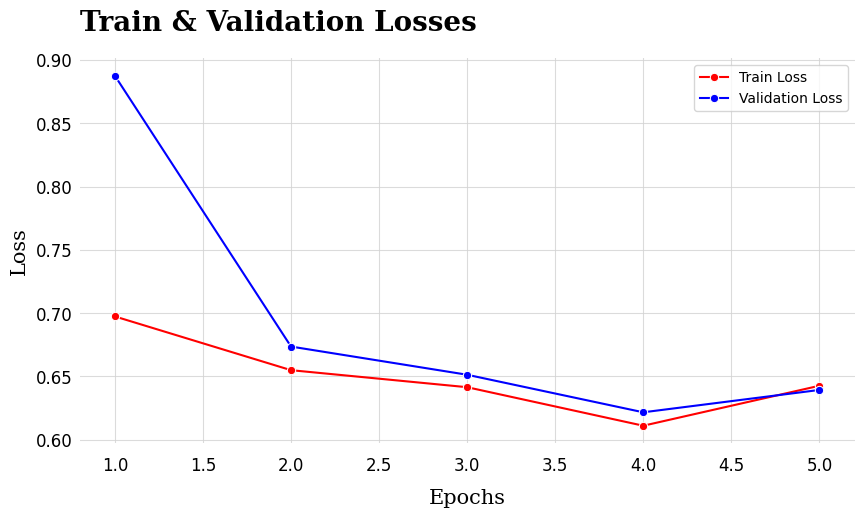

In [18]:
epochs_ = range(1, train_config.epochs+1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=trainer.history.train_losses, color="red", marker="o", label="Train Loss", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=trainer.history.validation_losses, color="blue", marker="o", label="Validation Loss", zorder=2, ax=ax)
ax.set_title("Train & Validation Losses", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
hide_spines(ax)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Loss", fontsize=15, fontfamily="serif", labelpad=5)
ax.legend()
fig.show()

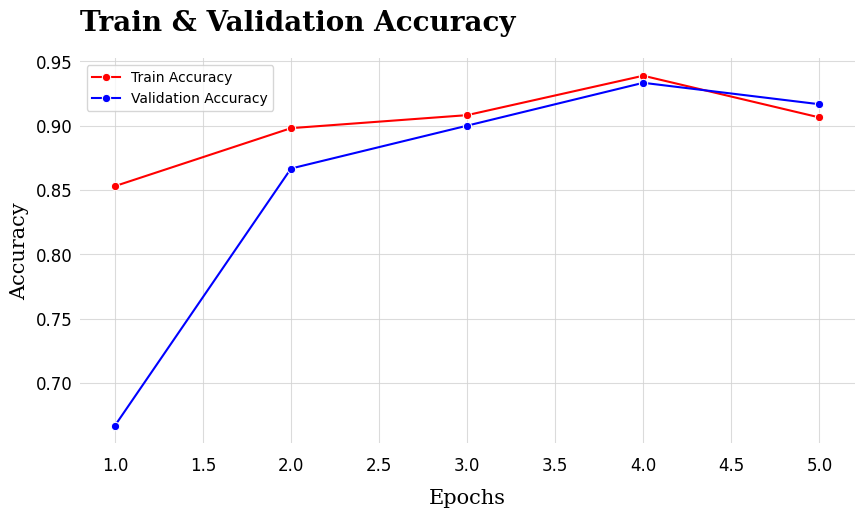

In [19]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
ax.grid(color="lightgrey", axis="both", alpha=0.8, zorder=0)
sns.lineplot(x=epochs_, y=trainer.history.train_scores, color="red", marker="o", label="Train Accuracy", zorder=2, ax=ax)
sns.lineplot(x=epochs_, y=trainer.history.validation_scores, color="blue", marker="o", label="Validation Accuracy", zorder=2, ax=ax)
ax.set_title("Train & Validation Accuracy", fontsize=20, fontweight="bold", fontfamily="serif", loc="left", y=1.05)
hide_spines(ax)
ax.xaxis.set_tick_params(labelsize=12, size=0, pad=10)
ax.yaxis.set_tick_params(labelsize=12, size=0, pad=5)
ax.set_xlabel("Epochs", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_ylabel("Accuracy", fontsize=15, fontfamily="serif", labelpad=5)
ax.legend()
fig.show()

**Predictions**

Predictions are generated using the trained model on the test data to evaluate performance.

**Explanation**

<img src="https://images.theconversation.com/files/288176/original/file-20190815-136190-cn8sg3.jpg?ixlib=rb-1.1.0&rect=0%2C793%2C5515%2C2753&q=45&auto=format&w=1356&h=668&fit=crop">

<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Inter:wght@500&display=swap" rel="stylesheet">


<h1 style="font-size: 30px; font-family: 'Inter', sans-serif;">Introducing to the Plant Disease Recognition Dataset</h1>
<p style="font-size: 17px; font-family: 'Inter', sans-serif;">This dataset contains three labels: <b>Healthy</b>, <b>Powdery</b>, <b>Rust</b> referring to plant conditions. There is a total of 1530 images divided into train, test, and validation sets.</p>

<h3 style="font-size: 25px; font-family: 'Inter', sans-serif;">Rusts</h3>
<p style="font-size: 17px; font-family: 'Inter', sans-serif;">
    
Rusts are plant diseases caused by pathogenic fungi of the order Pucciniales (previously known as Uredinales).

An estimated 168 rust genera and approximately 7,000 species, more than half of which belong to the genus Puccinia, are currently accepted.[1] Rust fungi are highly specialized plant pathogens with several unique features. Taken as a group, rust fungi are diverse and affect many kinds of plants. However, each species has a very narrow range of hosts and cannot be transmitted to non-host plants. In addition, most rust fungi cannot be grown easily in pure culture.

A single species of rust fungi may be able to infect two different plant hosts in different stages of its life cycle, and may produce up to five morphologically and cytologically distinct spore-producing structures viz., spermogonia, aecia, uredinia, telia, and basidia in successive stages of reproduction.[2] Each spore type is very host specific, and can typically infect only one kind of plant.

Rust fungi are obligate plant pathogens that only infect living plants. Infections begin when a spore lands on the plant surface, germinates, and invades its host. Infection is limited to plant parts such as leaves, petioles, tender shoots, stem, fruits, etc. Plants with severe rust infection may appear stunted, chlorotic (yellowed), or may display signs of infection such as rust fruiting bodies. Rust fungi grow intracellularly, and make spore-producing fruiting bodies within or, more often, on the surfaces of affected plant parts. Some rust species form perennial systemic infections that may cause plant deformities such as growth retardation, witch's broom, stem canker, galls, or hypertrophy of affected plant parts.

Rusts get their name because they are most commonly observed as deposits of powdery rust-coloured or brown spores on plant surfaces. The Roman agricultural festival Robigalia (April 25) has ancient origins in combating wheat rust.</p>

<img src="https://www.gardeningknowhow.com/wp-content/uploads/2020/11/plant-rust-disease.jpg" width="500px" height="300px">


<h3 style="font-size: 25px; font-family: 'Inter', sans-serif;">Powdery</h3>

<p style="font-size: 17px; font-family: 'Inter', sans-serif;">

Powdery mildew is a fungal disease that affects a wide range of plants. Powdery mildew diseases are caused by many different species of fungi in the order Erysiphales. Powdery mildew is one of the easier plant diseases to identify, as its symptoms are quite distinctive. Infected plants display white powdery spots on the leaves and stems. The lower leaves are the most affected, but the mildew can appear on any above-ground part of the plant. As the disease progresses, the spots get larger and denser as large numbers of asexual spores are formed, and the mildew may spread up and down the length of the plant.

Powdery mildew grows well in environments with high humidity and moderate temperatures. Greenhouses provide an ideal moist, temperate environment for the spread of the disease. This causes harm to agricultural and horticultural practices where powdery mildew may thrive in a greenhouse setting. In an agricultural or horticultural setting, the pathogen can be controlled using chemical methods, bio organic methods, and genetic resistance. It is important to be aware of powdery mildew and its management as the resulting disease can significantly reduce important crop yields.
</p>

<img src="https://media.istockphoto.com/photos/grapevine-diseases-downy-mildew-is-a-fungal-disease-that-affects-a-picture-id1161364148?k=6&m=1161364148&s=612x612&w=0&h=BzE8nsZHyGD3y7r1wvKIYDrvqLQcJdk_efFCUNB3134=" width="500px" height="300px">